In [9]:
import os
import numpy as np
import scipy.io
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Set the directory path and file names
data_dir = "/home/saher/Documents/data_preprocessed_matlab"
file_names = [f"s{i:02d}.mat" for i in range(1, 33)]  # s01.mat to s32.mat

# Initialize lists to hold data and labels
X_data = []
y_participant = []
y_clip = []

# Load and preprocess the data
for participant_id, file_name in enumerate(file_names, start=1):
    file_path = os.path.join(data_dir, file_name)
    mat = scipy.io.loadmat(file_path)
    
    # Assuming 'data' key holds the EEG data in the .mat file
    eeg_data = mat['data']  # shape: (40, 32, 8064)
    
    # Loop over each clip (40 clips per participant)
    for clip_id in range(40):
        clip_data = eeg_data[clip_id, :32, 384:]  # Skip first 3 seconds (3*128=384)
        
        # Loop over each second in the clip (60 seconds per clip)
        for second in range(60):
            start_idx = second * 128
            end_idx = (second + 1) * 128
            second_data = clip_data[:, start_idx:end_idx]
            
            X_data.append(second_data)
            y_participant.append(participant_id - 1)  # Zero-based index for labels
            y_clip.append(clip_id)  # Zero-based index for labels

# Convert lists to numpy arrays
X_data = np.array(X_data)
y_participant = np.array(y_participant)
y_clip = np.array(y_clip)

# Encode the labels
participant_encoder = LabelEncoder()
clip_encoder = LabelEncoder()

y_participant_encoded = participant_encoder.fit_transform(y_participant)
y_clip_encoded = clip_encoder.fit_transform(y_clip)

# Convert labels to one-hot encoding
y_participant_onehot = tf.keras.utils.to_categorical(y_participant_encoded, num_classes=len(participant_encoder.classes_))
y_clip_onehot = tf.keras.utils.to_categorical(y_clip_encoded, num_classes=len(clip_encoder.classes_))

# Scale the data
scaler = StandardScaler()
X_data = X_data.reshape(-1, 32 * 128)  # Flatten for scaling
X_data = scaler.fit_transform(X_data)
X_data = X_data.reshape(-1, 32, 128)  # Reshape back to original

# Split the data into training and test sets
X_train, X_test, y_train_participant, y_test_participant, y_train_clip, y_test_clip = train_test_split(
    X_data, y_participant_onehot, y_clip_onehot, test_size=0.2, random_state=42
)


In [11]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard


def create_model():
    input_layer = Input(shape=(32, 128))
    
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    
    # Output layers for multi-output classification
    participant_output = Dense(len(participant_encoder.classes_), activation='softmax', name='participant_output')(x)
    clip_output = Dense(len(clip_encoder.classes_), activation='softmax', name='clip_output')(x)
    
    # Create the model with two outputs
    model = Model(inputs=input_layer, outputs=[participant_output, clip_output])
    
    model.compile(optimizer='adam', 
                  loss={'participant_output': 'categorical_crossentropy', 'clip_output': 'categorical_crossentropy'},
                  metrics={'participant_output': 'accuracy', 'clip_output': 'accuracy'})
    return model

# Instantiate and train the model
model = create_model()

# Set up TensorBoard callback
log_dir = './logs'  # Directory where TensorBoard logs will be saved
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, {'participant_output': y_train_participant, 'clip_output': y_train_clip},
                    validation_data=(X_test, {'participant_output': y_test_participant, 'clip_output': y_test_clip}),
                    epochs=110, batch_size=32, callbacks=[tensorboard_callback])

# Notify user where to find TensorBoard logs
print(f"TensorBoard logs are saved to: {log_dir}")

Epoch 1/110
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - clip_output_accuracy: 0.0250 - loss: 5.4254 - participant_output_accuracy: 0.6574 - val_clip_output_accuracy: 0.0292 - val_loss: 3.8221 - val_participant_output_accuracy: 0.9866
Epoch 2/110
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - clip_output_accuracy: 0.0306 - loss: 3.8603 - participant_output_accuracy: 0.9774 - val_clip_output_accuracy: 0.0319 - val_loss: 3.7405 - val_participant_output_accuracy: 0.9948
Epoch 3/110
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - clip_output_accuracy: 0.0392 - loss: 3.7594 - participant_output_accuracy: 0.9893 - val_clip_output_accuracy: 0.0359 - val_loss: 3.7122 - val_participant_output_accuracy: 0.9969
Epoch 4/110
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - clip_output_accuracy: 0.0420 - loss: 3.7227 - participant_output_accuracy: 0.9913 - val_clip_output_accuracy: 0.0424 - val_loss: 3.6929 - val_participant_output_accuracy: 0.9971
Epoch 5/110
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step 

In [14]:
# Evaluate the model
scores = model.evaluate(X_test, {'participant_output': y_test_participant, 'clip_output': y_test_clip})


480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - clip_output_accuracy: 0.7135 - loss: 0.9885 - participant_output_accuracy: 0.9972


480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


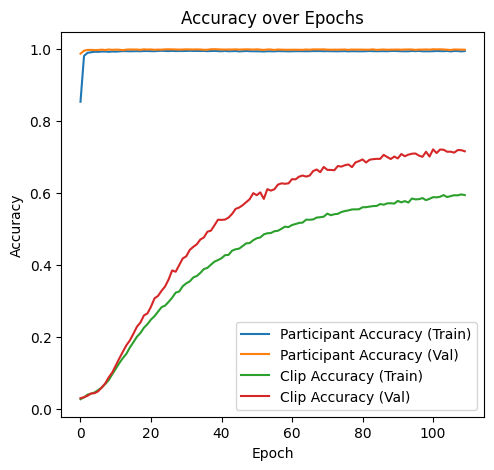